In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load data and checks on labels

Load the three labeled csv files and combine them in one dataframe. Plot also the total number of entries 
for each label using `pandas.DataFrame.describe` method.\
What we can notice is that the total number of bottom jets is approximately two times (four times) the number of charm jets (light jets).
This means that we have to properly normalize the amount of data per each class when we will split the total dataset in train, validation and test.
If we don't properly do this there could be the risk of introducing some error during the training stage, since the number of data with `mc_flavour = 5` is larger than the other two

In [5]:
ljet_data = pd.read_csv('jet_data/ljet_train.csv')
cjet_data = pd.read_csv('jet_data/cjet_train.csv')
bjet_data = pd.read_csv('jet_data/bjet_train.csv')

jet_data = pd.concat([ljet_data, cjet_data, bjet_data], axis=0).reset_index(drop=True)
n_labels = jet_data['mc_flavour'].unique()
print('List of different labels = ', n_labels)

# associate to each label a name
flavour_labels = {0: 'light jets', 4: 'charm jets', 5: 'bottom jets'}
for flavour, name in flavour_labels.items():
    print(f'Label {flavour}: {name}')

flavour_palette = {0:'blue', 4:'orange', 5:'red'}

List of different labels =  [0 4 5]
Label 0: light jets
Label 4: charm jets
Label 5: bottom jets


# PCA

PCA is needed to extract information from the features into a smaller number of uncorrelated components.Some features maybe highly correlated. With PCA we can remove redudant features and improve the training stage. The uncorrelated variable are called Principal Components (PCs). PCs capture the most variance in the data, and are linear combination of the original features. They also help improve visualization, because we have 15 features and in this way we can visualize them using 2D or 3D plots

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

In [4]:
# PCA considering all the features of the dataset. We can also use just a subset of the features highlighted before.
# Consider also labels
#PCA_features = ['PT', 'drSvrJet', 'nTrkJet', 'tau', 'ipChi2Sum']
PCA_features = jet_data.columns.values
PCA_features = np.delete(PCA_features, np.where(PCA_features == 'mc_flavour')) # delete mc_flavour since it is the label
print('Features selected for PCA:\n', PCA_features)

X = jet_data[PCA_features]
y = jet_data['mc_flavour']

# with_mean and with_std are by default True. This means that data will be shifted to have mean = 0 and variance = 1
std_scaler = StandardScaler(with_mean=True, with_std=True)

# X_scaled will have shape (n_samples, n_features). n_features = 14. So the array has n_samples elements, where each
# element is another containing transformed values of all 14 features, so that mean = 0 and variance = 1
X_scaled = std_scaler.fit_transform(X)

Features selected for PCA:
 ['PT' 'ETA' 'drSvrJet' 'fdChi2' 'fdrMin' 'm' 'mCor' 'mCorErr' 'nTrk'
 'nTrkJet' 'pt' 'ptSvrJet' 'tau' 'ipChi2Sum']


**Explained variace ratio:** percentage of variance explained by each selected component.
Do PCA wihtout specifying `n_components`, so that it is possible to see what is the cumulative variance considering different PCs.
Then we can do again PCA by selecting a specific number of `n_components`. For example one can set it when a given variance threshold is reached.

From the first plot we can see that variance is above 90-95 % when n_components > 8

Explained variance ratio without setting number of PCs:
 [0.23522941 0.39287126 0.51018384 0.60640823 0.68597319 0.75451359
 0.82053923 0.88245113 0.92751765 0.96384032 0.98157383 0.99327918
 0.9982489  1.        ]
Number of components to have variance higher than 0.99 =  12


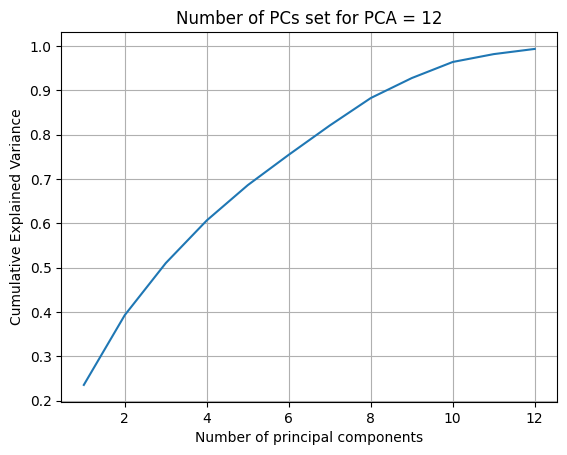

In [5]:
pca_all_components = PCA()
pca_all_components.fit(X_scaled)
explained_variance_ratio = np.cumsum(pca_all_components.explained_variance_ratio_)

variance_thr = 0.99
# use number of pricipal components such that variance is above a threshold
print('Explained variance ratio without setting number of PCs:\n', explained_variance_ratio)
components = np.where(explained_variance_ratio > variance_thr)[0]
print(f'Number of components to have variance higher than {variance_thr} = ', components[0]+1)

n_components = 12
pca = PCA(n_components=n_components)
pca.fit(X_scaled)
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
plt.title(f'Number of PCs set for PCA = {n_components}')
plt.xlabel('Number of principal components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

Plot of explained variance ratio: plot to see how much variance each principal component explains. Component 1 has the highest variance, which is also higher of all the other ones. The variance carried by other PCs is more "uniform"

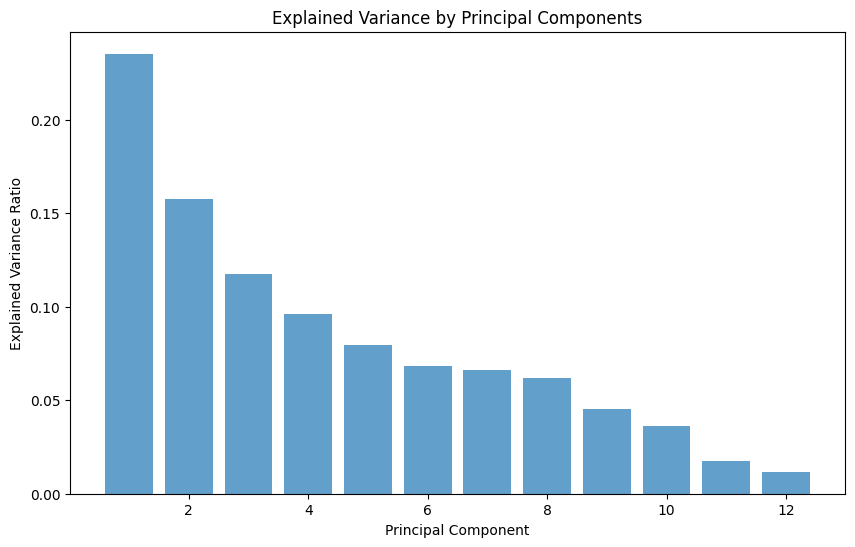

In [6]:
plt.figure(figsize=(10,6))
plt.bar(range(1,n_components+1), pca.explained_variance_ratio_, alpha=0.7, align='center')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

In [7]:
# this can be used to understand how much each feature contribute to the PC
loadings = pca.components_ # pca loadings
for i, component in enumerate(loadings[0:3]):
    print(f"Component {i+1}: {component}\n")


Component 1: [ 0.03212902  0.03479235 -0.07537787  0.04685139 -0.04696694  0.43551871
  0.37191813  0.04013135  0.45103018  0.41732079  0.33998544  0.34363539
 -0.16099998  0.14450966]

Component 2: [ 0.05272834 -0.04694998 -0.29105268  0.16453536  0.58078884 -0.10068041
 -0.20076587 -0.02192359  0.10617253  0.1426951   0.0540309   0.02829731
  0.51307551  0.44316026]

Component 3: [ 0.23211061 -0.19895211 -0.23351937 -0.07613437  0.13836149 -0.19799098
 -0.07935624  0.19292405 -0.30798776 -0.23960241  0.56059484  0.46063585
 -0.1337072  -0.21853647]



In [8]:
# compute feature importance from PCA loadings.
# Sum the importance of each feature in all PCs -> Why sum the squared of the importance?
feature_importance = np.sum(pca.components_**2, axis=0)
feature_names = jet_data.columns.drop('mc_flavour')

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)


      Feature  Importance
3      fdChi2    0.999981
7     mCorErr    0.999978
1         ETA    0.999936
12        tau    0.999527
4      fdrMin    0.998968
13  ipChi2Sum    0.998495
2    drSvrJet    0.997150
6        mCor    0.983762
5           m    0.958540
0          PT    0.904425
11   ptSvrJet    0.599511
9     nTrkJet    0.575768
10         pt    0.526388
8        nTrk    0.457572


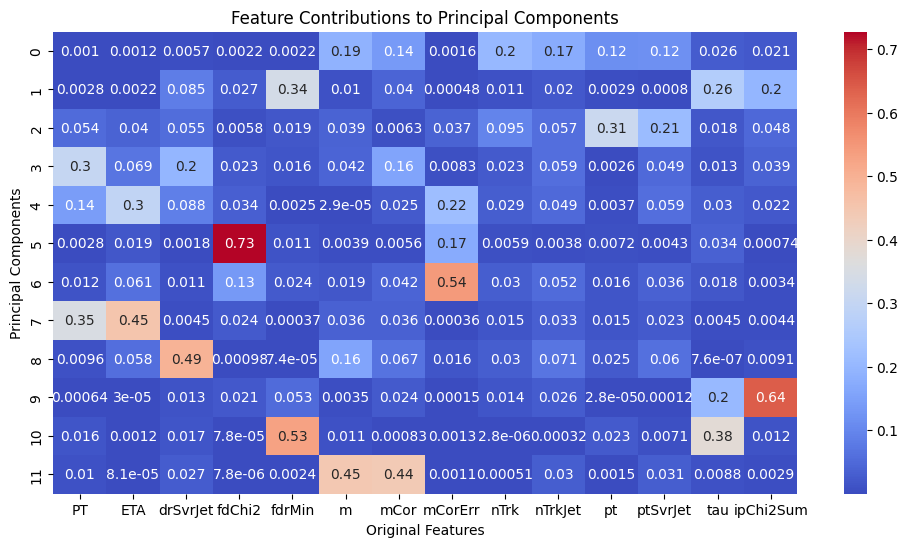

In [9]:
# heatmap of PCA components and feature contributions
plt.figure(figsize=(12,6))
iPC = 12
sns.heatmap(pca.components_[:iPC]**2, annot=True, cmap='coolwarm', 
            xticklabels=feature_names)
plt.title('Feature Contributions to Principal Components')
plt.xlabel('Original Features')
plt.ylabel('Principal Components')
plt.show()

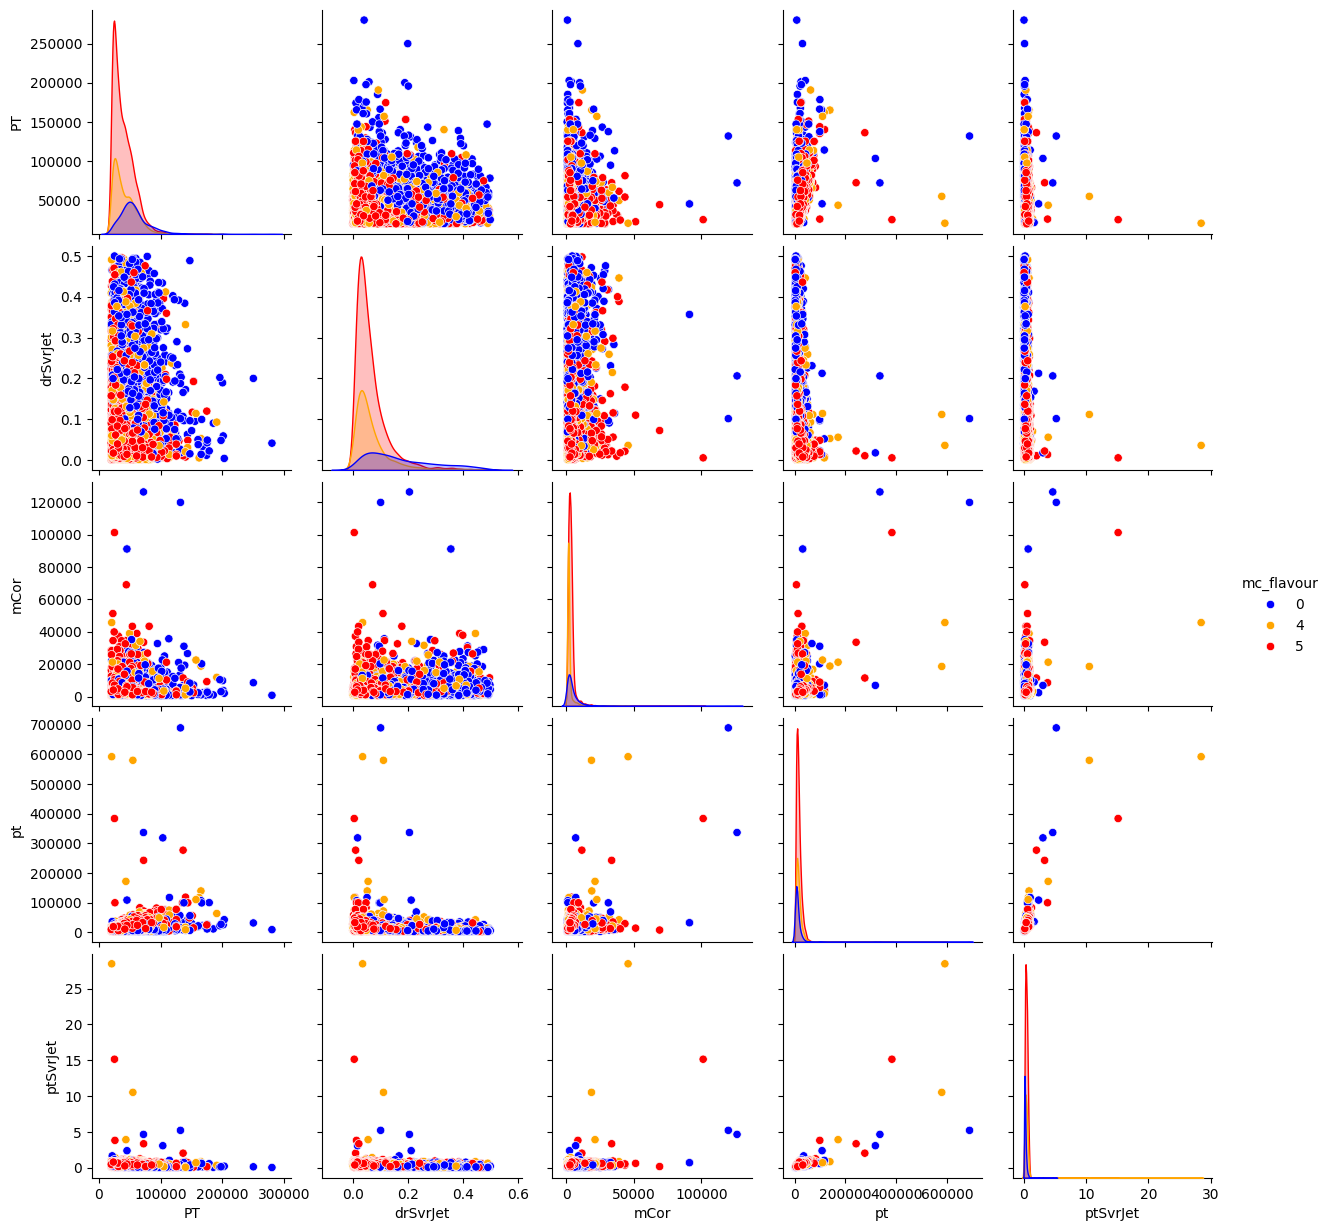

In [10]:
shuffled_jet_data = jet_data.sample(frac=0.1, random_state=42)  # frac=1 means keep all data, just shuffle

jet_data_pp = shuffled_jet_data[['PT', 'mc_flavour', 'drSvrJet', 'mCor', 'pt', 'ptSvrJet']].copy()

sns.pairplot(jet_data_pp, hue='mc_flavour', palette=flavour_palette)

# Random Forest for classification

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [7]:
features_for_training = jet_data.columns.drop(['mc_flavour', 'PT']) # use all the features except PT. Remove label column

X = jet_data[features_for_training] # input for random forest are data of the selected features
y = jet_data['mc_flavour'] # output: label of the jet

#PT_min, PT_max = jet_data['PT'].min(), 50_000 # low PT
#PT_min, PT_max = 50_000, 80_000               # mid PT
#PT_min, PT_max = 80_000, jet_data['PT'].max() # high PT

# filter the dataset based on PT range
#filtered_data : pd.DataFrame = jet_data[(jet_data['PT'] >= PT_min) & (jet_data['PT'] <= PT_max)]

# Drop 'mc_flavour' and 'PT' columns for training
#X = filtered_data.drop(columns=['mc_flavour', 'PT'])
#y = filtered_data['mc_flavour']

`stratify` parameter should account for features imbalance in the dataset

In [8]:
# split in training + test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42, stratify=y)

In [9]:
# check that label ratios have been preserved
print('Bottom-light ratio = ', y_train[y_train == 5].size / y_train[y_train == 0].size)
print('Charm-light ratio  = ', y_train[y_train == 4].size / y_train[y_train == 0].size)

Bottom-light ratio =  3.959487241504414
Charm-light ratio  =  1.620752207038336


### Ratios between bottom-light and charm-light are preserved after splitting

In [10]:
print("Training set size:", X_train.shape, y_train.shape)
print("Test set size:", X_test.shape, y_test.shape)

Training set size: (108824, 13) (108824,)
Test set size: (27206, 13) (27206,)


## Default Random Forest Classifier

In [16]:
# create a Random Forest Classifier with defaults parameters, except random_state for 
# reproducibility
n_estimators = [1,10,20,100] # 100 default of RandomForestClassifier

rnd_forest = RandomForestClassifier(random_state=42)
rnd_forest.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [17]:
y_test_pred = rnd_forest.predict(X_test)

print(f'Test dataset accuracy = {accuracy_score(y_test, y_test_pred)*100:.1f}')

Test dataset accuracy = 83.4


Training a random forest classifier with all default parameters gives an accuracy on test dataset of 76%, using only 5 features

Of course without specifying parameters the random forest is not optimised. Is it possible to improve the accuracy modifying the percetange of train and test samples? **What happens if the random forest is trained using all the features?**

With all the features the accuracy is 83.6%!! So this means that there are features relevant for the random forest training. Parameters are still not optimized. 

Without optimization of parameters and adding 3 more features, the accuracy is still 82.6%, so very close to what we get we all the features

In [18]:
importances = rnd_forest.feature_importances_
for feature, importance in zip(features_for_training, importances):
    print(f"{feature}: {importance:.4f}")


ETA: 0.0547
drSvrJet: 0.0831
fdChi2: 0.0964
fdrMin: 0.0618
m: 0.0723
mCor: 0.1442
mCorErr: 0.0714
nTrk: 0.0236
nTrkJet: 0.0266
pt: 0.0704
ptSvrJet: 0.1221
tau: 0.0695
ipChi2Sum: 0.1038


**What can we conclude by looking at these numbers?**
There are features that are important for PCA but they are not so relevant for training. For example `ETA`. 

`ETA` is the variable that carries the most variance according to PCA, but it is not very important for training. PCA measures how much variance each feature cntributes to the overall dataset (unsupervised), while Random Forest feature importance reflects how relevant each feature is for the target label (supervised)

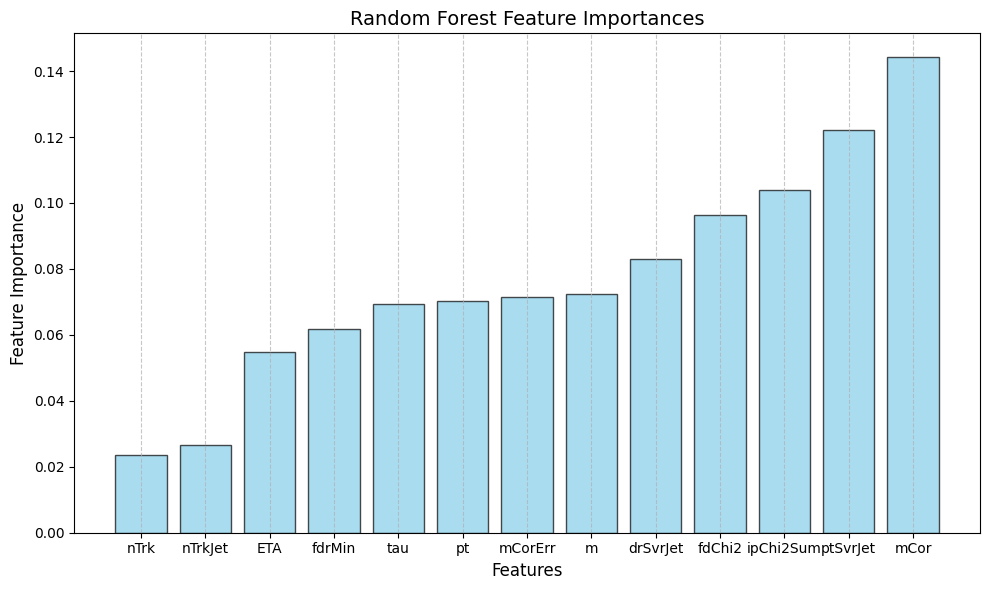

In [19]:
feature_importances = rnd_forest.feature_importances_
feature_names = features_for_training

# Sorting features by importance for better visualization
sorted_idx = np.argsort(feature_importances)
sorted_importances = np.array(feature_importances)[sorted_idx]
sorted_features = np.array(feature_names)[sorted_idx]

plt.figure(figsize=(10,6))
plt.bar(sorted_features, sorted_importances, color='skyblue', edgecolor='black', alpha=0.7)
plt.ylabel('Feature Importance', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.title('Random Forest Feature Importances', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Try to train without the less importan features
It shouldn't change nothing. In a more complex case, with more data for example, it is good remove useless features to speed up time needed for training. \
Remove `nTrk` and `nTrkJet` since they are the less important features

In [20]:
less_features_for_training = features_for_training.copy().drop(['nTrk', 'nTrkJet'])
X_less_features = jet_data.copy()[less_features_for_training]
y_less = jet_data['mc_flavour']

# create a new dataset without the two features
X_less_train, X_less_test = train_test_split(X_less_features, train_size=0.8, random_state=42)
y_less_train, y_less_test = train_test_split(y_less, train_size=0.8, random_state=42)

In [21]:
# train again the random forest without chaging parameters, just the training dataset
rnd_forest = RandomForestClassifier(random_state=42)
rnd_forest.fit(X_less_train, y_less_train)


y_pred_less = rnd_forest.predict(X_less_test)

print(f'Test dataset accuracy = {accuracy_score(y_less_test, y_pred_less)*100:.1f}')


Test dataset accuracy = 82.5


Accuracy excluding the less important features is 82.8. So what we can say is that is a little bit less, but in a more complex case with a larger dataset 
it can be useful to remove less important features to speed up training if we accept a 1% less in accuracy.
Since in this case computation time is low in both cases, we can keep all the features. This has to be checked also when training the random forest with optimized parameters

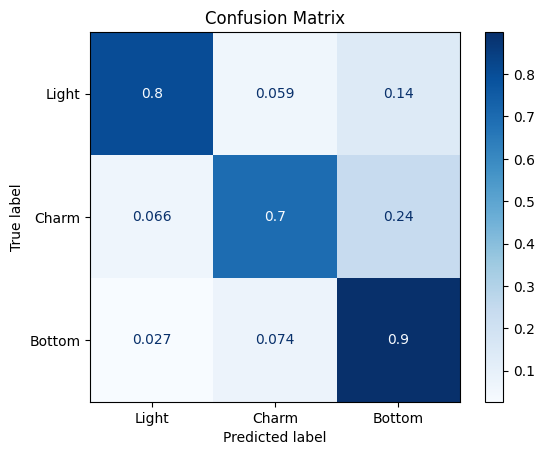

In [22]:
matrix = confusion_matrix(y_test, y_test_pred, normalize='true', labels=[0, 4, 5])

disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=['Light', 'Charm', 'Bottom'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


## Optimization of the Random Forest Classifier

In [11]:
from sklearn.model_selection import  RandomizedSearchCV, GridSearchCV
from sklearn.utils import resample

def parameters_search(method:str, par:dict, sample_fraction:float = 0.2, n_iter:int = 10, cv=5):
    res = None
    
    match method:
        case 'random' : res = RandomizedSearchCV(estimator=rnd_forest, param_distributions=par, n_iter=n_iter, cv=cv, n_jobs=-1, random_state=42)
            
        case 'grid' : res = GridSearchCV(estimator=rnd_forest, param_grid=par, cv=cv, scoring=None, n_jobs=-1)
            
    # sample a fraction of the training dataset for hyperparameter tuning
    X_train_sample, y_train_sample = resample(X_train, y_train, replace=False, n_samples=int(sample_fraction * len(X_train)), random_state=42)

    # do optimization on the resampled dataset
    res.fit(X_train_sample, y_train_sample)

    print(f'Best parameters with {method} search:\n', res.best_params_)
    print(f'sample fraction = {sample_fraction} \t iterations = {n_iter} \t number of cross validations = {cv}')
    return res.best_params_

In [14]:
search_space = {
    'n_estimators': np.arange(100, 1000, 50, int),  # number of trees in the forest
    'max_depth': np.arange(2, 60, 2, int),          # depth of each tree
    'min_samples_split': np.arange(2, 50, 2, int),  # minimum number of samples to split an internal node
    'min_samples_leaf': np.arange(1, 20, 2, int)    # 
}

In [25]:

best_par = parameters_search('random', search_space, sample_fraction=0.5, n_iter=10, cv=5)
#best_par = parameters_search('grid', search_space, sample_fraction=0.001, n_iter=3, cv=3)
#best_par = parameters_search('bayes', search_space, sample_fraction=0.01, n_iter=3, cv=3)

Best parameters with random search:
 {'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 50}
sample fraction = 0.5 	 iterations = 10 	 number of cross validations = 5


### Log results from parameters search:

Best parameters with random search:
 {'n_estimators': 100, 'min_samples_split': 18, 'min_samples_leaf': 3, 'max_depth': 12} \
sample fraction = 0.2 	 iterations = 10 	 number of cross validations = 5


Best parameters with random search:
 {'n_estimators': 100, 'min_samples_split': 18, 'min_samples_leaf': 3, 'max_depth': 12} \
sample fraction = 0.2 	 iterations = 15 	 number of cross validations = 5

Best parameters with random search:
 {'n_estimators': 200, 'min_samples_split': 24, 'min_samples_leaf': 7, 'max_depth': 16} \
sample fraction = 0.4 	 iterations = 10 	 number of cross validations = 5

Best parameters with random search:
 {'n_estimators': 450, 'min_samples_split': 18, 'min_samples_leaf': 7, 'max_depth': 18} \
sample fraction = 0.4 	 iterations = 10 	 number of cross validations = 5

Best parameters with random search:
 {'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 50} \
sample fraction = 0.2 	 iterations = 10 	 number of cross validations = 5

Best parameters with random search:
 {'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 50} \
sample fraction = 0.4 	 iterations = 10 	 number of cross validations = 5

Best parameters with random search:
 {'n_estimators': 650, 'max_depth': 34} \
sample fraction = 0.4 	 iterations = 10 	 number of cross validations = 5

Best parameters with random search:
 {'n_estimators': 250, 'min_samples_split': 14, 'min_samples_leaf': 5, 'max_depth': 18} \
sample fraction = 0.4 	 iterations = 10 	 number of cross validations = 5

Best parameters with random search:
 {'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 50} \
sample fraction = 0.5 	 iterations = 10 	 number of cross validations = 5


In [17]:
best_par = { 'n_estimators': 750,
             'min_samples_split': 2,
             'min_samples_leaf' : 1,
             'max_depth': 21,
             'criterion' : 'entropy'
}

In [20]:
rnd_forest_opt = RandomForestClassifier(n_estimators=best_par['n_estimators'], 
                                        min_samples_split=best_par['min_samples_split'], 
                                        min_samples_leaf=best_par['min_samples_leaf'], 
                                        max_depth=best_par['max_depth'],
                                        class_weight='balanced',
                                        criterion=best_par['criterion'])

rnd_forest_opt.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=21, n_estimators=1000)

In [21]:
y_test_pred = rnd_forest_opt.predict(X_test)

print(f'Test dataset accuracy = {accuracy_score(y_test, y_test_pred)*100:.1f}')

Test dataset accuracy = 83.5


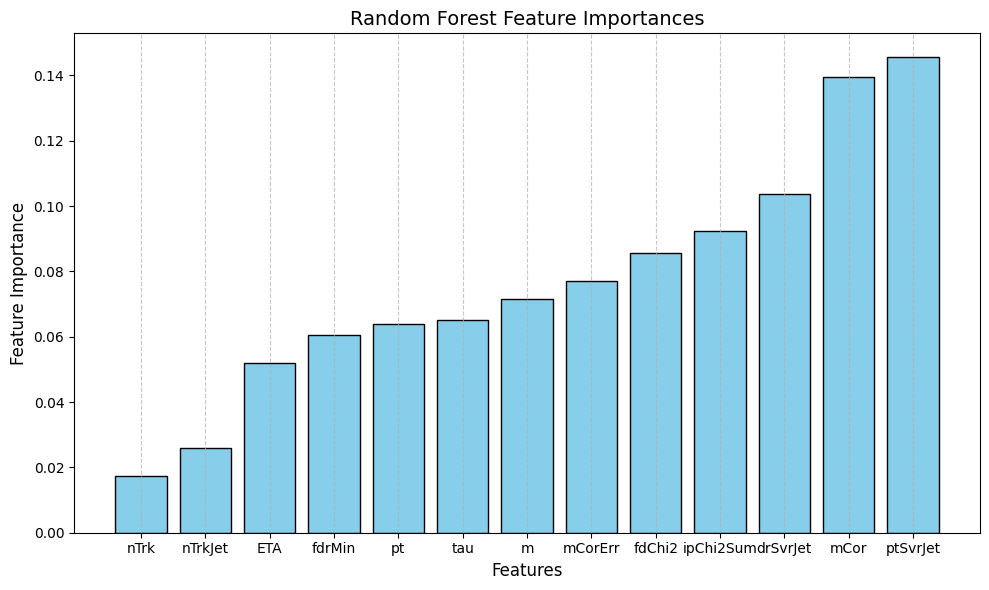

In [28]:
feature_importances = rnd_forest_opt.feature_importances_
feature_names = features_for_training

# Sorting features by importance for better visualization
sorted_idx = np.argsort(feature_importances)
sorted_importances = np.array(feature_importances)[sorted_idx]
sorted_features = np.array(feature_names)[sorted_idx]

plt.figure(figsize=(10,6))
plt.bar(sorted_features, sorted_importances, color='skyblue', edgecolor='black')
plt.ylabel('Feature Importance', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.title('Random Forest Feature Importances', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


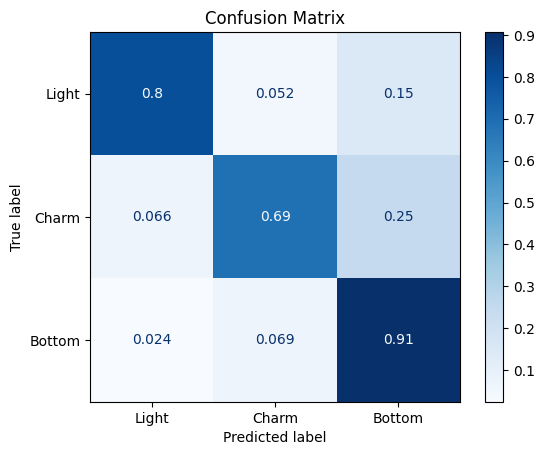

In [29]:
matrix = confusion_matrix(y_test, y_test_pred, normalize='true', labels=[0, 4, 5])

disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=['Light', 'Charm', 'Bottom'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()
